In [1]:
import tifffile
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sns

In [2]:
# judge if a is 0 or not
a = 0
if a==0:
    print("a is 0")
else:
    print("a is not 0")

a is 0


In [3]:
a = 1
if a==0:
    print("a is 0")
else:
    print("a is not 0")

a is not 0


In [4]:
# define a function, instead of writing the script every time
def iszero(num):
    if num==0:
        print("a is 0")
    else:
        print("a is not 0")

In [5]:
# use the function
a = 0
iszero(a)

a is 0


In [6]:
a = 10
iszero(a)

a is not 0


In [7]:
# functions can return values
def total_price(num_apple, num_orange):
    price_apple = num_apple * 100 # price of apple is 100/unit
    price_orange = num_orange * 80 # price of orange is 80/unit
    price_total = price_apple + price_orange
    
    return price_total # return the value of price_total

In [8]:
# use the function (buy 20 apples and 50 oranges)
price_total = total_price(20, 50)
print(price_total)

6000


In [9]:
# you can use any variable name for return values
you_pay = total_price(20, 50)
print(you_pay)

6000


Define functions for image segmentation and quantification

In [10]:
# define function to segment nuclei

def nuc_seg(img):
    # to remove very small fragments, blur image before thresholding
    img_0_blur = cv2.GaussianBlur(img[0], (7,7), 15)

    # automatic thresholding by Otsu method
    threshold, img_0_blur_bin = cv2.threshold(img_0_blur, 0, 1, cv2.THRESH_OTSU)
    img_0_blur_bin = img_0_blur_bin.astype(np.uint8) # convert from 16-bit to 8-bit

    # segmentation using the watershed algorithm
    coefficient = 0.4 # adjust this value (0-1)
    kernel = np.ones((5,5),np.uint8)
    sure_bg = cv2.dilate(img_0_blur_bin, kernel, iterations=3) # sure background
    dist_transform = cv2.distanceTransform(img_0_blur_bin, cv2.DIST_L2, 5) # distance map for sure foreground
    ret, sure_fg = cv2.threshold(dist_transform, coefficient*dist_transform.max(), 255, 0) # sure foreground
    sure_fg = np.uint8(sure_fg) # convert to 8-bit
    unknown = cv2.subtract(sure_bg, sure_fg) # unknown region
    ret, markers = cv2.connectedComponents(sure_fg) # label markers
    markers = markers+1 # increment all marker labels by "1" to set the background label to "1"
    markers[unknown==1] = 0 # assign "0" to unknown marker labels
    img_RGB = cv2.cvtColor(img_0_blur_bin, cv2.COLOR_GRAY2RGB)
    markers = cv2.watershed(img_RGB, markers) # watershed
    outlines = np.where(markers == -1, 255, 0)
    img_0_blur_bin2 = np.where(markers > 1, 1, 0).astype(np.uint8)

    # label masks
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img_0_blur_bin2, connectivity=4)

    return img_0_blur_bin2, retval, labels, stats, centroids

In [11]:
# import images (TIFF)
dir = "C:/Users/xxxx/xxxx" # change to your directory where the data file is
file1 = "HeLa_GM130_CENP-F_011.tif" # file name
file2 = "HeLa_GM130_CENP-F_012.tif"
img1 = tifffile.imread(os.path.join(dir, file1))
img2 = tifffile.imread(os.path.join(dir, file2))

# check the shape of imported image (should be an ndarray of 3 channnels, 1024 pixels in y, 1024 pixels in x)
print(img1.shape)
print(img2.shape)

(3, 1024, 1024)
(3, 1024, 1024)


In [12]:
# sengmentation of nuclei with img1
img1_bin, retval_1, labels_1, stats_1, centroids_1 = nuc_seg(img1)

# img2
img2_bin, retval_2, labels_2, stats_2, centroids_2 = nuc_seg(img2)

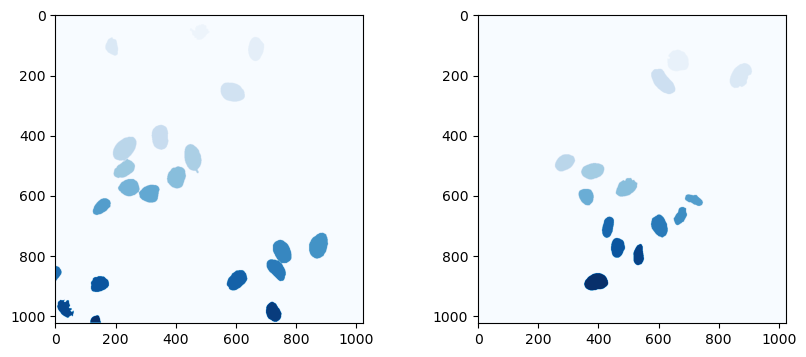

In [13]:
# show labeled masks
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(labels_1, cmap="Blues")
plt.subplot(122)
plt.imshow(labels_2, cmap="Blues")
plt.show()

In [14]:
# define function to make list of stats as dataframe (excluding mask 0 = background)

def make_df(stats, centroids):
    df_measurements = pd.DataFrame({"mask": np.array(range(1, len(centroids))),
                                    "x": centroids[1:, 0],
                                    "y": centroids[1:, 1],
                                    "area": stats[1:, 4] # mask area is in the list "stats"
                                    })
    
    return df_measurements

In [34]:
# define function to measure mean fluorescence intensities and standard deviations of nucleus regions

def measure_nuc(img, labels, centroids, df_measurements, filename):

    # prepare empty lists
    mean_hoechst = []
    std_hoechst = []
    mean_CENPF = []
    std_CENPF = []

    # measure
    for num in range (1, len(centroids)):
        mask = np.where(labels == num, 1, 0) # if the pixel value = num, assign 1, otherwise assign 0
        img_masked = img * mask # apply mask

        # channel 0
        img_masked_0 = img_masked[0]
        img_masked_0_nonzero = img_masked_0[np.nonzero(img_masked_0)] 
        mean_hoechst_ = np.mean(img_masked_0_nonzero) # mean of non-zero values in channel 0 (Hoechst)
        std_hoechst_ = np.std(img_masked_0_nonzero) # standard deviation

        # channel 2
        img_masked_2 = img_masked[2]
        img_masked_2_nonzero = img_masked_2[np.nonzero(img_masked_2)] 
        mean_CENPF_ = np.mean(img_masked_2_nonzero) # mean of non-zero values in channel 2 (CENP-F)
        std_CENPF_ = np.std(img_masked_2_nonzero) # standard deviation

        # append measured values to lists
        mean_hoechst.append(mean_hoechst_)
        std_hoechst.append(std_hoechst_)
        mean_CENPF.append(mean_CENPF_)
        std_CENPF.append(std_CENPF_)
    
    # add measured values to the dataframe
    df_measurements["mean_hoechst"] = mean_hoechst
    df_measurements["std_hoechst"] = std_hoechst
    df_measurements["mean_CENPF"] = mean_CENPF
    df_measurements["std_CENPF"] = std_CENPF
    df_measurements["file"] = filename

    return df_measurements

In [35]:
# make dfs
df_measurements_1 = make_df(stats_1, centroids_1)
df_measurements_2 = make_df(stats_2, centroids_2)

# show df
df_measurements_1

,mask,x,y,area
0,1,480.653959,55.738025,2046
1,2,665.297255,112.186525,3206
2,3,188.735546,105.058887,1868
3,4,587.514081,256.114625,4048
4,5,348.308171,405.687771,3696
5,6,230.468582,443.977558,4456
6,7,456.065404,474.259343,3960
7,8,229.680080,512.087860,2982
8,9,402.781567,539.216742,3548
9,10,245.757469,573.307099,3113


In [36]:
# measure
df_measurements_1 = measure_nuc(img1, labels_1, centroids_1, df_measurements_1, file1[:-4])
df_measurements_2 = measure_nuc(img2, labels_2, centroids_2, df_measurements_2, file2[:-4])

# combine dfs
df_concat = pd.concat([df_measurements_1, df_measurements_2]).reset_index()

#show df
df_concat

,index,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF,file
0,0,1,480.653959,55.738025,2046,514.936461,23.821097,442.864125,13.120656,HeLa_GM130_CENP-F_011
1,1,2,665.297255,112.186525,3206,592.418278,46.423886,480.299439,27.429127,HeLa_GM130_CENP-F_011
2,2,3,188.735546,105.058887,1868,534.826552,29.773429,445.887045,13.600470,HeLa_GM130_CENP-F_011
3,3,4,587.514081,256.114625,4048,611.501235,52.559340,501.022974,38.462082,HeLa_GM130_CENP-F_011
4,4,5,348.308171,405.687771,3696,554.175325,37.653001,462.627706,25.488484,HeLa_GM130_CENP-F_011
5,5,6,230.468582,443.977558,4456,615.193896,49.463709,520.398788,45.629067,HeLa_GM130_CENP-F_011
6,6,7,456.065404,474.259343,3960,633.990657,58.884579,501.851515,40.978008,HeLa_GM130_CENP-F_011
7,7,8,229.680080,512.087860,2982,575.049631,49.036945,464.936284,24.185469,HeLa_GM130_CENP-F_011
8,8,9,402.781567,539.216742,3548,558.778185,40.452912,462.271984,23.213038,HeLa_GM130_CENP-F_011
9,9,10,245.757469,573.307099,3113,572.201413,38.595253,467.324767,26.244144,HeLa_GM130_CENP-F_011


In [37]:
# you can combine functions together

def seg_measure(img, filename):
    img_bin, retval, labels, stats, centroids = nuc_seg(img)
    df_measurements = make_df(stats, centroids)
    df_measurements = measure_nuc(img, labels, centroids, df_measurements, filename[:-4])
    return img_bin, df_measurements

In [38]:
# now you can efficiently run routine

img1_bin, df_measurements_1 = seg_measure(img1, "HeLa_GM130_CENP-F_011.tif")
img2_bin, df_measurements_2 = seg_measure(img2, "HeLa_GM130_CENP-F_012.tif")

df_concat = pd.concat([df_measurements_1, df_measurements_2]).reset_index()

df_concat

,index,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF,file
0,0,1,480.653959,55.738025,2046,514.936461,23.821097,442.864125,13.120656,HeLa_GM130_CENP-F_011
1,1,2,665.297255,112.186525,3206,592.418278,46.423886,480.299439,27.429127,HeLa_GM130_CENP-F_011
2,2,3,188.735546,105.058887,1868,534.826552,29.773429,445.887045,13.600470,HeLa_GM130_CENP-F_011
3,3,4,587.514081,256.114625,4048,611.501235,52.559340,501.022974,38.462082,HeLa_GM130_CENP-F_011
4,4,5,348.308171,405.687771,3696,554.175325,37.653001,462.627706,25.488484,HeLa_GM130_CENP-F_011
5,5,6,230.468582,443.977558,4456,615.193896,49.463709,520.398788,45.629067,HeLa_GM130_CENP-F_011
6,6,7,456.065404,474.259343,3960,633.990657,58.884579,501.851515,40.978008,HeLa_GM130_CENP-F_011
7,7,8,229.680080,512.087860,2982,575.049631,49.036945,464.936284,24.185469,HeLa_GM130_CENP-F_011
8,8,9,402.781567,539.216742,3548,558.778185,40.452912,462.271984,23.213038,HeLa_GM130_CENP-F_011
9,9,10,245.757469,573.307099,3113,572.201413,38.595253,467.324767,26.244144,HeLa_GM130_CENP-F_011


In [39]:
# save df as a CSV file
df_concat.to_csv(os.path.join(dir, "df_concat.csv"))

In [40]:
# load df from the CSV
# you can use the data for subsequent analysis
df_concat = pd.read_csv(os.path.join(dir, "df_concat.csv"), index_col=0)
df_concat

,index,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF,file
0,0,1,480.653959,55.738025,2046,514.936461,23.821097,442.864125,13.120656,HeLa_GM130_CENP-F_011
1,1,2,665.297255,112.186525,3206,592.418278,46.423886,480.299439,27.429127,HeLa_GM130_CENP-F_011
2,2,3,188.735546,105.058887,1868,534.826552,29.773429,445.887045,13.600470,HeLa_GM130_CENP-F_011
3,3,4,587.514081,256.114625,4048,611.501235,52.559340,501.022974,38.462082,HeLa_GM130_CENP-F_011
4,4,5,348.308171,405.687771,3696,554.175325,37.653001,462.627706,25.488484,HeLa_GM130_CENP-F_011
5,5,6,230.468582,443.977558,4456,615.193896,49.463709,520.398788,45.629067,HeLa_GM130_CENP-F_011
6,6,7,456.065404,474.259343,3960,633.990657,58.884579,501.851515,40.978008,HeLa_GM130_CENP-F_011
7,7,8,229.680080,512.087860,2982,575.049631,49.036945,464.936284,24.185469,HeLa_GM130_CENP-F_011
8,8,9,402.781567,539.216742,3548,558.778185,40.452912,462.271984,23.213038,HeLa_GM130_CENP-F_011
9,9,10,245.757469,573.307099,3113,572.201413,38.595253,467.324767,26.244144,HeLa_GM130_CENP-F_011


In [42]:
# search for ".tif" files in the directry "dir"
files = [file for file in os.listdir(dir) if file.endswith('.tif')]

# show the files found
for file in files:
    print(file)

HeLa_GM130_CENP-F_011.tif
HeLa_GM130_CENP-F_012.tif


In [ ]:
# can you define a function to automatically pick up all TIFF files in a directory and output a concatenated dataframe?
# it's easy to process just 2 images, but it's not reallistic to process hundreds of images manually